## 0 Setup
These are the same packages as in the last exercise:

In [1]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import namedtuple
import itertools

from DQN import DQN
from utils import make_epsilon_greedy_policy, linear_epsilon_decay

In [3]:
import heapq
import torch

class PrioritizedReplayBuffer:
    def __init__(self, max_size: int, alpha: float = 0.2):
        """
        Create the replay buffer that uses softmax-based sampling over priorities.
        A heap is used to keep track of the maximum raw priority so that new transitions
        are given a high (max) priority.

        :param max_size: Maximum number of transitions in the buffer.
        :param alpha: Exponent for converting raw priorities into sampling probabilities.
                      The probability of sampling transition i will be:
                          p(i) = (priority_i ** alpha) / sum_j (priority_j ** alpha)
        """
        self.max_size = max_size
        self.alpha = alpha
        
        # We use raw priorities. New transitions are assigned a default max priority.
        self.max_priority = 1.0

        self.pointer = 0      # Next insertion index.
        self.size = 0         # Current number of stored transitions.

        # The replay buffer (list of transitions).
        self.buffer = [None] * max_size
        
        # An array of raw priorities for each stored transition.
        self.priorities = [0.0] * max_size
        
        # A heap for quick retrieval of the maximum priority.
        # We store tuples of (-priority, index) so that the highest priority is at the top.
        self.heap = []
    
    def __len__(self) -> int:
        """Returns the number of transitions currently in the buffer."""
        return self.size

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor,
              next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Add a new transition to the buffer. When the buffer is full, the oldest transition
        is overwritten. The new transition is assigned the current maximum raw priority.

        :param obs: Current observation.
        :param action: Action taken.
        :param reward: Reward received.
        :param next_obs: Next observation.
        :param terminated: Terminal flag.
        """
        idx = self.pointer
        transition = (obs, action, reward, next_obs, terminated)
        self.buffer[idx] = transition
        
        # New transition gets the current maximum raw priority.
        self.priorities[idx] = self.max_priority
        
        # Push onto the heap (we use negative because heapq is a min-heap).
        heapq.heappush(self.heap, (-self.max_priority, idx))
        
        # Update pointer and size.
        self.pointer = (self.pointer + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    
    def update_experience_priorities(self, indices: list[int], priorities: torch.Tensor):
        """
        Update the raw priorities for the transitions at the given indices.

        :param indices: List of indices to update.
        :param priorities: A torch.Tensor containing the new raw priority values.
        """
        for idx, priority in zip(indices, priorities):
            # Convert the priority to a Python float.
            p_val = float(priority)
            
            self.priorities[idx] = p_val
            
            # Push the updated priority onto the heap.
            heapq.heappush(self.heap, (-p_val, idx))
            
            # Update the maximum priority if necessary.
            if p_val > self.max_priority:
                self.max_priority = p_val

    def _compute_sampling_probabilities(self):
        """
        Compute sampling probabilities for all stored transitions based on softmax over
        (alpha * log(raw_priority)). In effect, this returns:
            p(i) = (priority_i ** alpha) / sum_j (priority_j ** alpha)
        A small epsilon is added to avoid log(0).
        """
        eps = 1e-6  # To prevent taking log(0)
        # Only consider the "active" part of the buffer.
        prios = torch.tensor(self.priorities[:self.size], dtype=torch.float32)
        # Compute logits = alpha * log(raw_priority)
        logits = self.alpha * torch.log(prios + eps)
        # Use softmax to compute sampling probabilities.
        sampling_probs = torch.softmax(logits, dim=0)
        return sampling_probs

    def _compute_importance_weights(self, indices: list[int], sampling_probs: torch.Tensor, beta: float):
        """
        Compute importance-sampling weights based on the sampling probabilities.
        For index i the weight is computed as:
            w(i) = (1 / (N * p(i))) ** beta
        The weights are normalized by dividing by the maximum weight.
        :param indices: List of sampled indices.
        :param sampling_probs: The vector of sampling probabilities over the stored transitions.
        :param beta: The exponent for importance sampling correction.
        :return: A list of importance sampling weights.
        """
        N = self.size
        weights = []
        for idx in indices:
            p_i = sampling_probs[idx].item()
            weight = (1.0 / (N * p_i)) ** beta
            weights.append(weight)
        # Normalize weights by the maximum weight to avoid excessively large updates.
        max_weight = max(weights)
        weights = [w / max_weight for w in weights]
        return weights

    def sample(self, batch_size: int, beta: float):
        """
        Sample a batch of transitions according to softmax over priorities.
        Also computes importance-sampling weights to correct for the bias
        introduced by prioritized sampling.

        :param batch_size: Number of transitions to sample.
        :param beta: The exponent used in computing importance-sampling weights.
                     Should be positive (often annealed toward 1 during training).
        :returns: A tuple:
                  (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch,
                   sampled_indices, importance_weights)
        """
        assert self.size >= batch_size, "Not enough samples to draw from."
        assert beta > 0, "Beta should be positive for IS weight correction."
        
        # Compute sampling probabilities for all stored transitions.
        sampling_probs = self._compute_sampling_probabilities()
        
        # Sample indices according to the computed probabilities.
        # Using torch.multinomial allows weighted random sampling.
        indices_tensor = torch.multinomial(sampling_probs, batch_size, replacement=True)
        indices = indices_tensor.tolist()
        
        # Compute importance-sampling weights.
        weights = self._compute_importance_weights(indices, sampling_probs, beta)
        
        # Retrieve the sampled transitions.
        transitions = [self.buffer[idx] for idx in indices]
        obs, actions, rewards, next_obs, terminated = zip(*transitions)
        
        # Convert observations and next observations to tensors (cloning/detaching if necessary).
        obs_batch = torch.stack([o.clone().detach() for o in obs])
        next_obs_batch = torch.stack([n.clone().detach() for n in next_obs])
        # Convert actions, rewards, and terminated flags to tensors.
        action_batch = torch.tensor(actions)
        reward_batch = torch.tensor(rewards)
        terminated_batch = torch.tensor(terminated)
        weights_tensor = torch.tensor(weights, dtype=torch.float32)
        
        return (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch,
                indices, weights_tensor)


In [4]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        indices: list,
        weights: torch.Tensor,
        memory: PrioritizedReplayBuffer,
        priority_eps: float = 1e-6,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # Calculate the TD-Target
    with torch.no_grad():
        q_s_prime = q_target(next_obs)

        max_q_s_prime = torch.max(q_s_prime, dim=1)[0]
        td_target = rew + gamma * max_q_s_prime * ~tm

    # Calculate the loss. Hint: Pytorch has the ".gather()" function, which collects values along a specified axis using some specified indexes
    q_s_a = torch.gather(q(obs), dim=1, index=act.unsqueeze(1)).squeeze(1)
    elementwise_loss = F.smooth_l1_loss(q_s_a, td_target, reduction="none")
    
    loss = torch.mean(elementwise_loss * weights)

    # Backpropagate the loss and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    td_delta = elementwise_loss.detach().cpu().numpy()
    new_priorities = td_delta + priority_eps
    memory.update_experience_priorities(indices, new_priorities)

    return loss.item()

In [5]:
import itertools
import heapq
from collections import namedtuple
import numpy as np
import torch
import torch.optim as optim

# Assume that the following functions and classes are defined elsewhere:
#   - DQN (your Q-network model)
#   - make_epsilon_greedy_policy (returns a callable policy)
#   - linear_epsilon_decay (computes epsilon from a linear schedule)
#   - update_dqn (performs one gradient update step on the Q-network)
#   - PrioritizedReplayBuffer (the replay buffer implementation)

EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class DQNAgent:
    def __init__(self,
                 env,
                 total_frames: int = 1_000_000,  # Total number of frames to train on.
                 frame_skip: int = 4,            # Only select a new action every `frame_skip` frames.
                 gamma: float = 0.99,
                 lr: float = 0.001,
                 batch_size: int = 64,
                 eps_start: float = 1.0,
                 eps_end: float = 0.1,
                 schedule_duration: int = 500_000,  # Schedule based on frames.
                 update_freq: int = 100,
                 maxlen: int = 100_000,
                 alpha: float = 0.2,
                 beta: float = 0.6,
                 squared_grad_momentum: float = 0.95,
                 min_squared_grad: float = 0.01):
        """
        Initialize the DQN agent with frame skipping.

        :param env: The environment.
        :param total_frames: Total number of frames to train on.
        :param frame_skip: The number of frames to skip (i.e. repeat the same action).
        :param gamma: Discount factor.
        :param lr: Learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: Initial epsilon value.
        :param eps_end: Final epsilon value.
        :param schedule_duration: Duration (in frames) over which epsilon is annealed.
        :param update_freq: Frequency (in frames) at which to update the target network.
        :param maxlen: Maximum number of transitions in the replay buffer.
        :param alpha: Priority exponent.
        :param beta: Importance sampling exponent.
        :param squared_grad_momentum: RMSProp momentum parameter.
        :param min_squared_grad: RMSProp epsilon.
        """
        self.env = env
        self.total_frames = total_frames
        self.frame_skip = frame_skip
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.beta = beta

        # Initialize the Replay Buffer
        self.replay_buffer = PrioritizedReplayBuffer(maxlen, alpha)

        # Initialize the Deep Q-Network and its target.
        self.q = DQN(self.env.observation_space.shape, self.env.action_space.n)
        self.q_target = DQN(self.env.observation_space.shape, self.env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        # Create the optimizer.
        self.optimizer = optim.RMSprop(self.q.parameters(), lr=lr, alpha=squared_grad_momentum, centered=True, eps=min_squared_grad)

        # Create the epsilon-greedy policy.
        self.policy = make_epsilon_greedy_policy(self.q, self.env.action_space.n)

    def train(self) -> EpisodeStats:
        """
        Train the DQN agent using frame skipping.
        Training runs until a total of `total_frames` frames have been experienced.
        
        :returns: Episode statistics (lengths and rewards) for completed episodes.
        """
        stats = EpisodeStats(
            episode_lengths=[],
            episode_rewards=[]
        )

        frame_count = 0  # Total frames experienced (including skipped frames)
        episode_num = 0

        while frame_count < self.total_frames:
            # Reset environment for a new episode.
            obs, _ = self.env.reset()
            episode_reward = 0.0
            episode_length = 0

            done = False

            # In each episode, the agent selects actions every frame_skip frames.
            while not done and frame_count < self.total_frames:
                # Compute epsilon from a linear schedule based on total frames.
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, frame_count, self.schedule_duration)

                # Select action using the epsilon-greedy policy.
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)

                total_reward = 0.0
                last_obs = obs

                # Execute the same action for `frame_skip` frames (or until termination).
                for skip in range(self.frame_skip):
                    next_obs, reward, terminated, truncated, _ = self.env.step(action)
                    total_reward += reward
                    frame_count += 1
                    episode_length += 1

                    # If termination occurs during a skip, break early.
                    if terminated or truncated:
                        done = True
                        break
                    last_obs = next_obs

                # Store the transition from the beginning of the skip to the last observation.
                self.replay_buffer.store(
                    torch.tensor(obs),
                    torch.tensor(action),
                    torch.tensor(total_reward),
                    torch.tensor(last_obs),
                    torch.tensor(terminated or truncated)
                )

                episode_reward += total_reward
                obs = last_obs

                # Update beta gradually based on frame_count.
                fraction = min(frame_count / self.total_frames, 1.0)
                self.beta = self.beta + fraction * (1.0 - self.beta)

                # Update the Q-network if enough transitions are available.
                if len(self.replay_buffer) > self.batch_size:
                    obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch, indices, weights = self.replay_buffer.sample(self.batch_size, self.beta)

                    update_dqn(
                        self.q,
                        self.q_target,
                        self.optimizer,
                        self.gamma,
                        obs_batch.float(),
                        act_batch,
                        rew_batch.float(),
                        next_obs_batch.float(),
                        tm_batch,
                        indices,
                        weights,
                        self.replay_buffer
                    )

                    # Update the target network every update_freq frames.
                    if frame_count % self.update_freq == 0:
                        self.q_target.load_state_dict(self.q.state_dict())

            # End of episode: log stats.
            stats.episode_lengths.append(episode_length)
            stats.episode_rewards.append(episode_reward)
            episode_num += 1

            if episode_num % 10 == 0:
                print(f"Episode: {episode_num}, Frames: {frame_count}, Reward: {episode_reward:.2f}")

        # Convert stats lists to numpy arrays if desired.
        stats = EpisodeStats(
            episode_lengths=np.array(stats.episode_lengths),
            episode_rewards=np.array(stats.episode_rewards)
        )
        return stats


In [6]:
# Choose your environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 1000

LR = 0.00025
EPS_START = 1.0
EPS_END = 0.1
NUM_EPISODES = 5000
SCHEDULE_DURATION = 0.2 * NUM_EPISODES
ALPHA = 0.5
BETA = 0.4
DISCOUNT_FACTOR = 0.99
SQUARED_GRAD_MOMENTUM = 0.95
MIN_SQUARED_GRAD = 0.01

# Train DQN
agent = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    alpha=ALPHA,
    beta=BETA,
    squared_grad_momentum=SQUARED_GRAD_MOMENTUM,
    min_squared_grad=MIN_SQUARED_GRAD,
    total_frames=100000
)
stats = agent.train()

Training on MinAtar/Breakout-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(3)

Episode: 10, Frames: 80, Reward: 0.00
Episode: 20, Frames: 160, Reward: 0.00
Episode: 30, Frames: 250, Reward: 1.00
Episode: 40, Frames: 310, Reward: 0.00
Episode: 50, Frames: 380, Reward: 0.00
Episode: 60, Frames: 490, Reward: 0.00
Episode: 70, Frames: 580, Reward: 0.00
Episode: 80, Frames: 690, Reward: 0.00
Episode: 90, Frames: 800, Reward: 0.00
Episode: 100, Frames: 900, Reward: 1.00
Episode: 110, Frames: 1030, Reward: 1.00
Episode: 120, Frames: 1160, Reward: 1.00
Episode: 130, Frames: 1260, Reward: 0.00
Episode: 140, Frames: 1370, Reward: 1.00
Episode: 150, Frames: 1480, Reward: 0.00
Episode: 160, Frames: 1590, Reward: 1.00
Episode: 170, Frames: 1690, Reward: 0.00
Episode: 180, Frames: 1830, Reward: 1.00
Episode: 190, Frames: 1920, Reward: 1.00
Episode: 200, Frames: 2010, Reward: 0.00
Episode: 210, Frames: 2130, Reward: 1.00
Episode: 220, Frames: 2240, Reward: 0.00
Epis

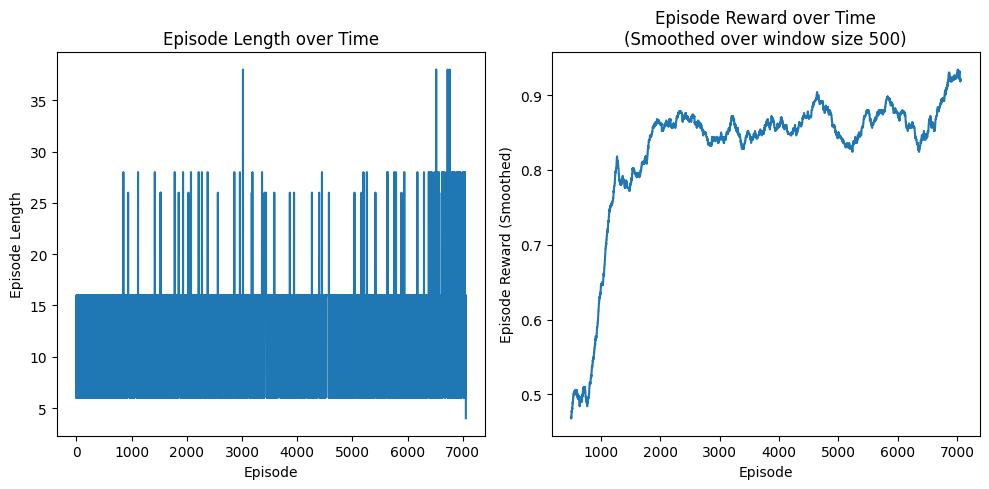

In [13]:
smoothing_window=500
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

In [8]:
# smoothing_window=500
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# # Plot the episode length over time
# ax = axes[0]
# ax.plot(stats.episode_lengths)
# ax.set_xlabel("Episode")
# ax.set_ylabel("Episode Length")
# ax.set_title("Episode Length over Time") 

# # Plot the episode reward over time
# ax = axes[1]
# rewards_smoothed = df["reward"].rolling(smoothing_window, min_periods=smoothing_window).mean()
# ax.plot(rewards_smoothed)
# ax.set_xlabel("Episode")
# ax.set_ylabel("Episode Reward (Smoothed)")
# ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
# plt.show()

In [9]:
df = pd.read_csv("../results/freeway_dqn_stats.csv")

In [10]:
df

,episode,length,reward
0,1,501.0,0.0
1,2,501.0,0.0
2,3,501.0,0.0
3,4,501.0,0.0
4,5,501.0,0.0
...,...,...,...
9995,9996,501.0,9.0
9996,9997,501.0,9.0
9997,9998,501.0,8.0
9998,9999,501.0,8.0


In [11]:
df = pd.DataFrame({
    "episode": range(1, len(stats.episode_lengths) + 1),
    "length": stats.episode_lengths,
    "reward": stats.episode_rewards
})

save_path = "../results/freeeway_per_stats.csv"

df.to_csv(save_path, index=False)

/home/lilit/miniconda3/envs/lab_project/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/home/lilit/miniconda3/envs/lab_project/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:276: UserWarning: WARN: RGB-array rendering should return a numpy array with dtype uint8, got float64
  logger.warn(


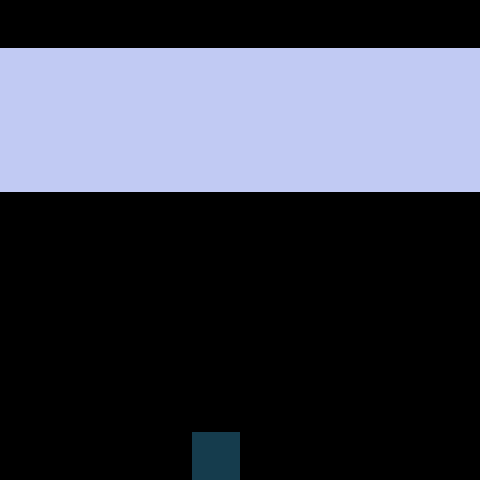

In [12]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

We have not trained very far because it can be very time consuming. But feel free to change the hyperparameters and try to improve your results!

---
<span style="color:orange">**EXERCISE**</span>: **The deadly triad** (2 points)

In Sutton and Barto's "Reinforcement Learning: An Introduction" they introduced the concept of the **Deadly Triad**. Investigate this concept and explain in your own words what it describes. What does it say about DQNs?

**Your answers here:**

The Deadly triad consists of three factors: Bootstrapping, Function Approximation, and Off-Policy learning. The three combined have the danger of divergence. With bootstrapping you use the estimated values of next states to update the current state, which can become problematic, as the weights of the network are updated simultaneously for every state with function approximation. When using Off-Policy learning, the agent might learn on actions that the target would take infrequently and when expectations are increased, they can be left unchecked, blowing off and leading to divergence. DQNs use all three. 

In the book it is mentioned that if the behavior policy is sufficiently close to the target, like in the case of epsilon-greedy, Q-learning is not found to diverge. They then discuss using methods of avoiding the deadly triad such as using MC to avoid Bootstrapping or Sarsa to be On-Policy. One can also use Double Q-learning, Target Net

---
<span style="color:orange">**EXERCISE**</span>: **Going beyond discrete action spaces** (1.5 points)

1. What is the difference between discrete and continuous action spaces?
2. Name a key problem that may arise by using DQN for continuous action spaces. Hint: Think about how we select a greedy action.


**Your answers here:**
1. One chooses a discrete action and the other has continous space. Like choosing Left or Right or choosing how much Left or Right.
2. When you take the max over actions, it is easy to for discrete actions as you can enumerate and iterate, which you can't do for the continous case. 

---
<span style="color:orange">**FEEDBACK**</span>

Describe your experience with this exercise and the course. We have set up an anonymous option for this in ILIAS or you can write your feedback directly here in the notebook. Please note that your feedback will help us to improve the course.

I really enjoyed this exercise. It was the right amount of challenge, in my opinion, at least for me. I think a test for the update_dqn function would be a nice addition, as it can fail silently, due to the broadcasting of torch tensors. This was at least the case for me, but luckily the bug was found quickly. 